# Hessian of CNN (Input layer)

https://qiita.com/shiita0903/items/b41cb370dd9aab5e382c

In [80]:
import numpy as np
import tensorflow as tf

import keras
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.datasets import mnist

from tqdm import tqdm_notebook as tqdm
from scipy.stats import norm

In [81]:
with keras.utils.CustomObjectScope({'GlorotUniform': keras.initializers.glorot_uniform()}):
        model = keras.models.load_model('trained_model/trained_cnn_v0.h5', compile=False)

In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 784)               0         
_________________________________________________________________
fc_1 (Dense)                 (None, 512)               401920    
_________________________________________________________________
relu_1 (Activation)          (None, 512)               0         
_________________________________________________________________
fc_2 (Dense)                 (None, 256)               131328    
_________________________________________________________________
relu_2 (Activation)          (None, 256)               0         
_________________________________________________________________
fc_3 (Dense)                 (None, 256)               65792     
_________________________________________________________________
relu_3 (Activation)          (None, 256)               0         
__________

In [83]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
del mnist

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Ohe-Hot encoding
y_train = keras.utils.np_utils.to_categorical(y_train) 
y_test  = keras.utils.np_utils.to_categorical(y_test) 

In [84]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


In [85]:
# y_pred
y_pred = model.predict(x_train[0].reshape(1, 28, 28))
print("y_pred", y_pred.shape)

# y_true
y_true = y_train[0].reshape(1, -1)
print("y_true", y_true.shape)

y_pred (1, 10)
y_true (1, 10)


In [86]:
idx = 0

x_true = x_train[idx].reshape(1, 28, 28)
y_true = y_train[idx].reshape(1, -1)
y_pred = model.output

init = tf.global_variables_initializer()
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
get_grad = K.gradients(loss, model.input)

sess = K.get_session()
sess.run(init)
gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})
# d output / d input

gradient = gradient.flatten()
gradient.shape

(784,)

(784, 784)


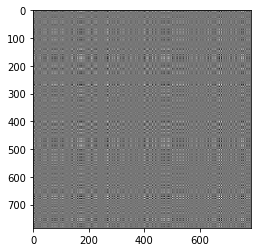

In [138]:
hessian_martix = np.outer(gradient, gradient)

print(hessian_martix.shape)

plt.imshow(hessian_martix, "gray")
plt.show()

In [139]:
hessian_matrix[0:3, 0:3]

array([[1.3319913e-22, 7.8046074e-23, 2.1104011e-23],
       [7.8046055e-23, 4.6391525e-23, 1.2466962e-23],
       [2.1104064e-23, 1.2466941e-23, 3.3614278e-24]], dtype=float32)

In [202]:
idx = 11

x_true = x_train[idx].reshape(1, 28, 28)
y_true = y_train[idx].reshape(1, -1)
y_pred = model.output

init = tf.global_variables_initializer()
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
get_grad = K.gradients(loss, model.input)

sess = K.get_session()
sess.run(init)
gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})
# d output / d input

gradient = gradient.reshape(-1)
hessian_matrix = np.outer(gradient, gradient)

In [203]:
eig_values, eig_vectors = np.linalg.eigh(hessian_matrix)

eig_values = eig_values.astype(np.float32)
eig_vectors = eig_vectors.astype(np.float32)

for i in range(len(eig_vectors)):
    eig_vectors[i] = eig_vectors[i] / np.linalg.norm(eig_vectors[i], ord=2)
    
max_eig_vector = eig_vectors[np.argmax(eig_values)]
max_eig_vector.shape

(784,)

Original (1, 28, 28)


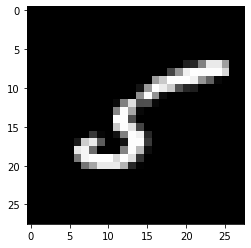

Gradient (784,)


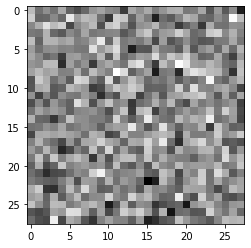

Hessian Diag matrix (28, 28)


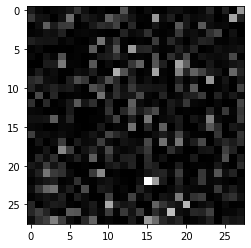

Hessian matrix (784, 784)


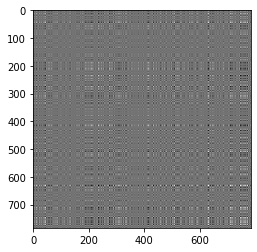

Input to maximize FI (28, 28)


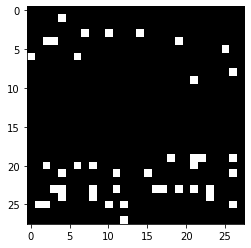

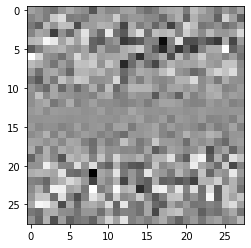

In [204]:
# Original

print("Original", x_true.shape)
plt.imshow(x_true.reshape(28,28), "gray")
plt.show()


# Gradient

print("Gradient", gradient.shape)
plt.imshow(gradient.reshape(28,28), "gray")
plt.show()


# Hessian (diag)

print("Hessian Diag matrix", np.diag(hessian_matrix).reshape(28,28).shape)
plt.imshow(np.diag(hessian_matrix).reshape(28,28), "gray")
plt.show()

# Hessian (diag)

print("Hessian matrix", hessian_matrix.shape)
plt.imshow(hessian_matrix, "gray")
plt.show()

# maximize FisherInformation

print("Input to maximize FI", max_eig_vector.reshape(28,28).shape)

max_fim = max_eig_vector.reshape(28,28)
max_fim = (max_fim - max_fim.min()) / (max_fim.max() - max_fim.min())
plt.imshow(np.where(max_fim < 0.85, 0, 1), "gray")
plt.show()

plt.imshow(max_eig_vector.reshape(28,28), "gray")
plt.show()

## Experiments

Original (1, 28, 28)


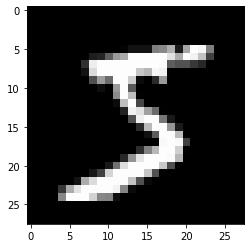

Gradient (784,)


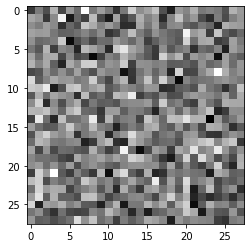

Hessian Diag matrix (28, 28)


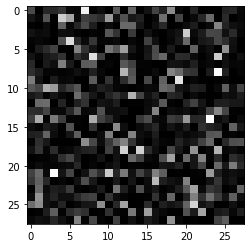

Hessian matrix (784, 784)


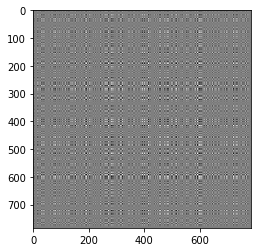

Input to maximize FI (28, 28)


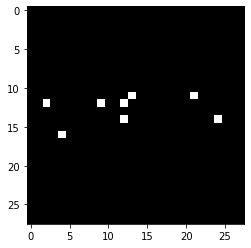

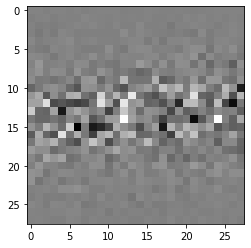

In [205]:
idx = 0

x_true = x_train[idx].reshape(1, 28, 28)
y_true = y_train[idx].reshape(1, -1)
y_pred = model.output

init = tf.global_variables_initializer()
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
get_grad = K.gradients(loss, model.input)

sess = K.get_session()
sess.run(init)
gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})
# d output / d input

gradient = gradient.reshape(-1)
hessian_matrix = np.outer(gradient, gradient)


eig_values, eig_vectors = np.linalg.eigh(hessian_matrix)

eig_values = eig_values.astype(np.float32)
eig_vectors = eig_vectors.astype(np.float32)

for i in range(len(eig_vectors)):
    eig_vectors[i] = eig_vectors[i] / np.linalg.norm(eig_vectors[i], ord=2)
    
max_eig_vector = eig_vectors[np.argmax(eig_values)]


# Original

print("Original", x_true.shape)
plt.imshow(x_true.reshape(28,28), "gray")
plt.show()


# Gradient

print("Gradient", gradient.shape)
plt.imshow(gradient.reshape(28,28), "gray")
plt.show()


# Hessian (diag)

print("Hessian Diag matrix", np.diag(hessian_matrix).reshape(28,28).shape)
plt.imshow(np.diag(hessian_matrix).reshape(28,28), "gray")
plt.show()

# Hessian (diag)

print("Hessian matrix", hessian_matrix.shape)
plt.imshow(hessian_matrix, "gray")
plt.show()

# maximize FisherInformation

print("Input to maximize FI", max_eig_vector.reshape(28,28).shape)

max_fim = max_eig_vector.reshape(28,28)
max_fim = (max_fim - max_fim.min()) / (max_fim.max() - max_fim.min())
plt.imshow(np.where(max_fim < 0.85, 0, 1), "gray")
plt.show()

plt.imshow(max_eig_vector.reshape(28,28), "gray")
plt.show()

Original (1, 28, 28)


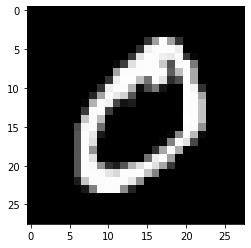

Gradient (784,)


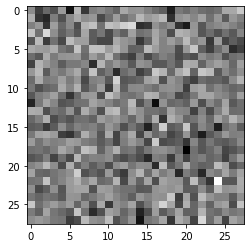

Hessian Diag matrix (28, 28)


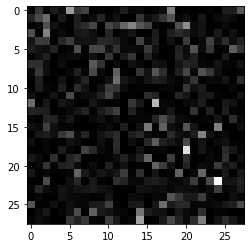

Hessian matrix (784, 784)


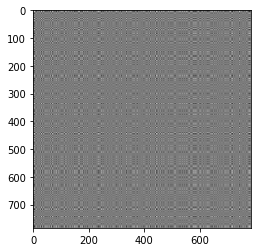

Input to maximize FI (28, 28)


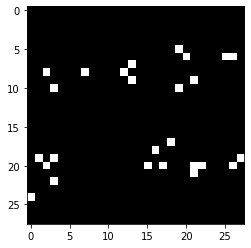

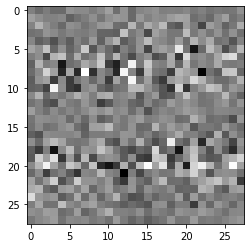

In [221]:
idx = 1

x_true = x_train[idx].reshape(1, 28, 28)
y_true = y_train[idx].reshape(1, -1)
y_pred = model.output

init = tf.global_variables_initializer()
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
get_grad = K.gradients(loss, model.input)

sess = K.get_session()
sess.run(init)
gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})

# gradient = gradient.flatten()
gradient = gradient.reshape(-1)
hessian_matrix = np.outer(gradient, gradient)


eig_values, eig_vectors = np.linalg.eigh(hessian_matrix)

eig_values = eig_values.astype(np.float32)
eig_vectors = eig_vectors.astype(np.float32)

for i in range(len(eig_vectors)):
    eig_vectors[i] = eig_vectors[i] / np.linalg.norm(eig_vectors[i], ord=2)
    
max_eig_vector = eig_vectors[np.argmax(eig_values)]


# Original

print("Original", x_true.shape)
plt.imshow(x_true.reshape(28,28), "gray")
plt.show()


# Gradient

print("Gradient", gradient.shape)
plt.imshow(gradient.reshape(28,28), "gray")
plt.show()


# Hessian (diag)

print("Hessian Diag matrix", np.diag(hessian_matrix).reshape(28,28).shape)
plt.imshow(np.diag(hessian_matrix).reshape(28,28), "gray")
plt.show()

# Hessian (diag)

print("Hessian matrix", hessian_matrix.shape)
plt.imshow(hessian_matrix, "gray")
plt.show()

# maximize FisherInformation

print("Input to maximize FI", max_eig_vector.reshape(28,28).shape)

max_fim = max_eig_vector.reshape(28,28)
max_fim = (max_fim - max_fim.min()) / (max_fim.max() - max_fim.min())
plt.imshow(np.where(max_fim < 0.8, 0, 1), "gray")
plt.show()

plt.imshow(max_eig_vector.reshape(28,28), "gray")
plt.show()

Original (1, 28, 28)


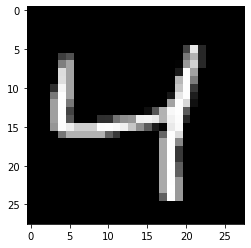

Gradient (784,)


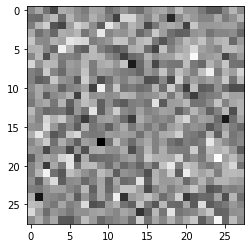

Hessian Diag matrix (28, 28)


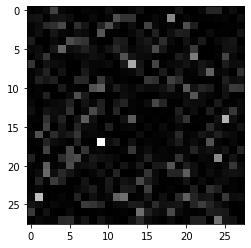

Hessian matrix (784, 784)


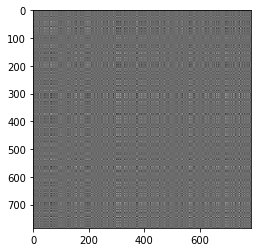

Input to maximize FI (28, 28)


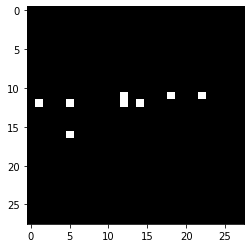

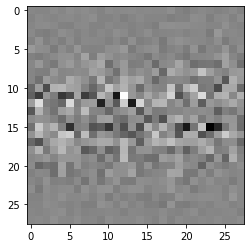

In [220]:
idx = 2

x_true = x_train[idx].reshape(1, 28, 28)
y_true = y_train[idx].reshape(1, -1)
y_pred = model.output

init = tf.global_variables_initializer()
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
get_grad = K.gradients(loss, model.input)

sess = K.get_session()
sess.run(init)
gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})

# gradient = gradient.flatten()
gradient = gradient.reshape(-1)
hessian_matrix = np.outer(gradient, gradient)


eig_values, eig_vectors = np.linalg.eigh(hessian_matrix)

eig_values = eig_values.astype(np.float32)
eig_vectors = eig_vectors.astype(np.float32)

for i in range(len(eig_vectors)):
    eig_vectors[i] = eig_vectors[i] / np.linalg.norm(eig_vectors[i], ord=2)
    
max_eig_vector = eig_vectors[np.argmax(eig_values)]


# Original

print("Original", x_true.shape)
plt.imshow(x_true.reshape(28,28), "gray")
plt.show()


# Gradient

print("Gradient", gradient.shape)
plt.imshow(gradient.reshape(28,28), "gray")
plt.show()


# Hessian (diag)

print("Hessian Diag matrix", np.diag(hessian_matrix).reshape(28,28).shape)
plt.imshow(np.diag(hessian_matrix).reshape(28,28), "gray")
plt.show()

# Hessian (diag)

print("Hessian matrix", hessian_matrix.shape)
plt.imshow(hessian_matrix, "gray")
plt.show()

# maximize FisherInformation

print("Input to maximize FI", max_eig_vector.reshape(28,28).shape)

max_fim = max_eig_vector.reshape(28,28)
max_fim = (max_fim - max_fim.min()) / (max_fim.max() - max_fim.min())
plt.imshow(np.where(max_fim < 0.8, 0, 1), "gray")
plt.show()

plt.imshow(max_eig_vector.reshape(28,28), "gray")
plt.show()

Original (1, 28, 28)


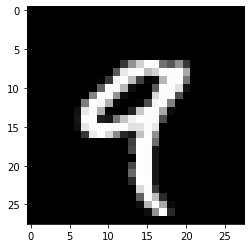

Gradient (784,)


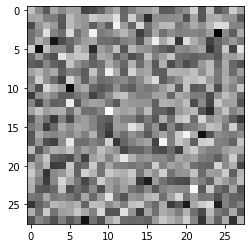

Hessian Diag matrix (28, 28)


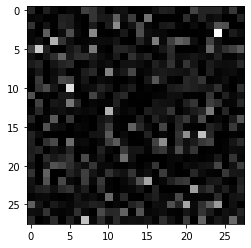

Hessian matrix (784, 784)


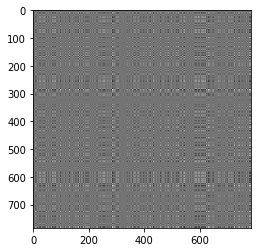

Input to maximize FI (28, 28)


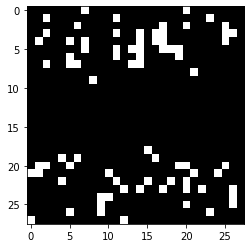

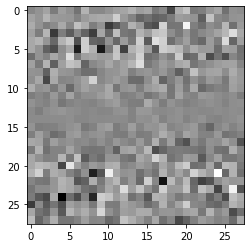

In [219]:
idx = 4

x_true = x_train[idx].reshape(1, 28, 28)
y_true = y_train[idx].reshape(1, -1)
y_pred = model.output

init = tf.global_variables_initializer()
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
get_grad = K.gradients(loss, model.input)

sess = K.get_session()
sess.run(init)
gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})

# gradient = gradient.flatten()
gradient = gradient.reshape(-1)
hessian_matrix = np.outer(gradient, gradient)

eig_values, eig_vectors = np.linalg.eigh(hessian_matrix)

eig_values = eig_values.astype(np.float32)
eig_vectors = eig_vectors.astype(np.float32)

for i in range(len(eig_vectors)):
    eig_vectors[i] = eig_vectors[i] / np.linalg.norm(eig_vectors[i], ord=2)
    
max_eig_vector = eig_vectors[np.argmax(eig_values)]


# Original

print("Original", x_true.shape)
plt.imshow(x_true.reshape(28,28), "gray")
plt.show()


# Gradient

print("Gradient", gradient.shape)
plt.imshow(gradient.reshape(28,28), "gray")
plt.show()


# Hessian (diag)

print("Hessian Diag matrix", np.diag(hessian_matrix).reshape(28,28).shape)
plt.imshow(np.diag(hessian_matrix).reshape(28,28), "gray")
plt.show()

# Hessian (diag)

print("Hessian matrix", hessian_matrix.shape)
plt.imshow(hessian_matrix, "gray")
plt.show()

# maximize FisherInformation

print("Input to maximize FI", max_eig_vector.reshape(28,28).shape)

max_fim = max_eig_vector.reshape(28,28)
max_fim = (max_fim - max_fim.min()) / (max_fim.max() - max_fim.min())
plt.imshow(np.where(max_fim < 0.7, 0, 1), "gray")
plt.show()

plt.imshow(max_eig_vector.reshape(28,28), "gray")
plt.show()

Original (1, 28, 28)


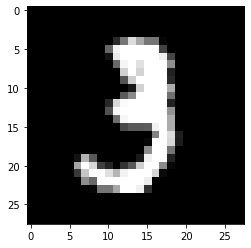

Gradient (784,)


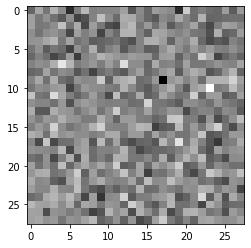

Hessian Diag matrix (28, 28)


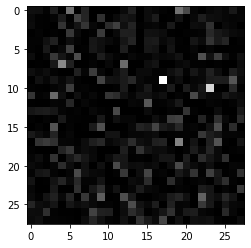

Hessian matrix (784, 784)


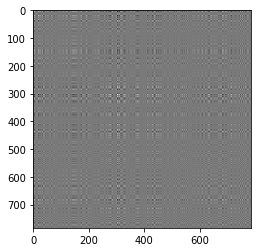

Input to maximize FI (28, 28)


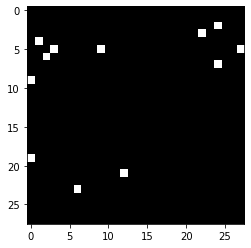

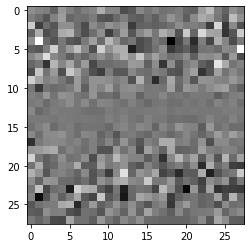

In [217]:
idx = 10

x_true = x_train[idx].reshape(1, 28, 28)
y_true = y_train[idx].reshape(1, -1)
y_pred = model.output

init = tf.global_variables_initializer()
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
get_grad = K.gradients(loss, model.input)

sess = K.get_session()
sess.run(init)
gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})

# gradient = gradient.flatten()
gradient = gradient.reshape(-1)
hessian_matrix = np.outer(gradient, gradient)


eig_values, eig_vectors = np.linalg.eigh(hessian_matrix)

eig_values = eig_values.astype(np.float32)
eig_vectors = eig_vectors.astype(np.float32)

for i in range(len(eig_vectors)):
    eig_vectors[i] = eig_vectors[i] / np.linalg.norm(eig_vectors[i], ord=2)
    
max_eig_vector = eig_vectors[np.argmax(eig_values)]


# Original

print("Original", x_true.shape)
plt.imshow(x_true.reshape(28,28), "gray")
plt.show()


# Gradient

print("Gradient", gradient.shape)
plt.imshow(gradient.reshape(28,28), "gray")
plt.show()


# Hessian (diag)

print("Hessian Diag matrix", np.diag(hessian_matrix).reshape(28,28).shape)
plt.imshow(np.diag(hessian_matrix).reshape(28,28), "gray")
plt.show()

# Hessian (diag)

print("Hessian matrix", hessian_matrix.shape)
plt.imshow(hessian_matrix, "gray")
plt.show()

# maximize FisherInformation

print("Input to maximize FI", max_eig_vector.reshape(28,28).shape)

max_fim = max_eig_vector.reshape(28,28)
max_fim = (max_fim - max_fim.min()) / (max_fim.max() - max_fim.min())
plt.imshow(np.where(max_fim < 0.8, 0, 1), "gray")
plt.show()

plt.imshow(max_eig_vector.reshape(28,28), "gray")
plt.show()

Original (1, 28, 28)


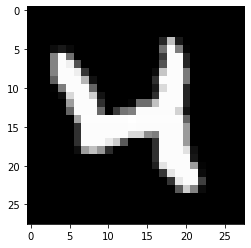

Gradient (784,)


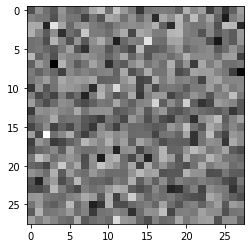

Hessian Diag matrix (28, 28)


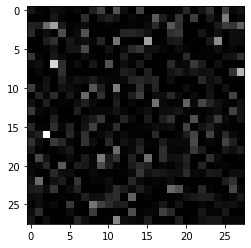

Hessian matrix (784, 784)


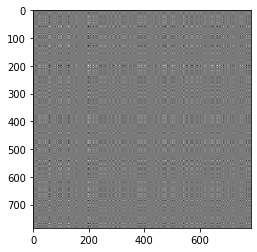

Input to maximize FI (28, 28)


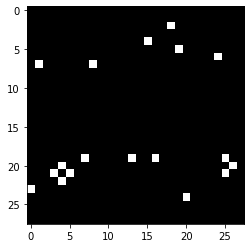

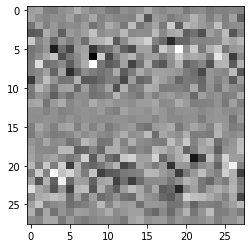

In [216]:
idx = 20

x_true = x_train[idx].reshape(1, 28, 28)
y_true = y_train[idx].reshape(1, -1)
y_pred = model.output

init = tf.global_variables_initializer()
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
get_grad = K.gradients(loss, model.input)

sess = K.get_session()
sess.run(init)
gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})

# gradient = gradient.flatten()
gradient = gradient.reshape(-1)
hessian_matrix = np.outer(gradient, gradient)


eig_values, eig_vectors = np.linalg.eigh(hessian_matrix)

eig_values = eig_values.astype(np.float32)
eig_vectors = eig_vectors.astype(np.float32)

for i in range(len(eig_vectors)):
    eig_vectors[i] = eig_vectors[i] / np.linalg.norm(eig_vectors[i], ord=2)
    
max_eig_vector = eig_vectors[np.argmax(eig_values)]


# Original

print("Original", x_true.shape)
plt.imshow(x_true.reshape(28,28), "gray")
plt.show()


# Gradient

print("Gradient", gradient.shape)
plt.imshow(gradient.reshape(28,28), "gray")
plt.show()


# Hessian (diag)

print("Hessian Diag matrix", np.diag(hessian_matrix).reshape(28,28).shape)
plt.imshow(np.diag(hessian_matrix).reshape(28,28), "gray")
plt.show()

# Hessian (diag)

print("Hessian matrix", hessian_matrix.shape)
plt.imshow(hessian_matrix, "gray")
plt.show()

# maximize FisherInformation

print("Input to maximize FI", max_eig_vector.reshape(28,28).shape)

max_fim = max_eig_vector.reshape(28,28)
max_fim = (max_fim - max_fim.min()) / (max_fim.max() - max_fim.min())
plt.imshow(np.where(max_fim < 0.8, 0, 1), "gray")
plt.show()

plt.imshow(max_eig_vector.reshape(28,28), "gray")
plt.show()

Original (1, 28, 28)


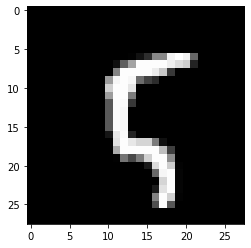

Gradient (784,)


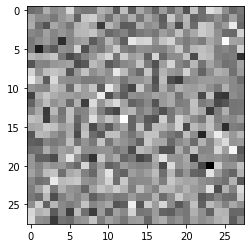

Hessian Diag matrix (28, 28)


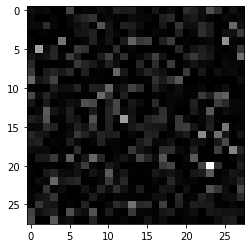

Hessian matrix (784, 784)


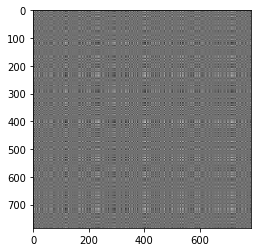

Input to maximize FI (28, 28)


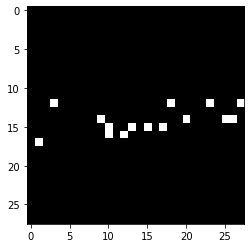

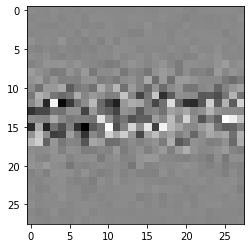

In [215]:
idx = 100

x_true = x_train[idx].reshape(1, 28, 28)
y_true = y_train[idx].reshape(1, -1)
y_pred = model.output

init = tf.global_variables_initializer()
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
get_grad = K.gradients(loss, model.input)

sess = K.get_session()
sess.run(init)
gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})

# gradient = gradient.flatten()
gradient = gradient.reshape(-1)
hessian_matrix = np.outer(gradient, gradient)


eig_values, eig_vectors = np.linalg.eigh(hessian_matrix)

eig_values = eig_values.astype(np.float32)
eig_vectors = eig_vectors.astype(np.float32)

for i in range(len(eig_vectors)):
    eig_vectors[i] = eig_vectors[i] / np.linalg.norm(eig_vectors[i], ord=2)
    
max_eig_vector = eig_vectors[np.argmax(eig_values)]


# Original

print("Original", x_true.shape)
plt.imshow(x_true.reshape(28,28), "gray")
plt.show()


# Gradient

print("Gradient", gradient.shape)
plt.imshow(gradient.reshape(28,28), "gray")
plt.show()


# Hessian (diag)

print("Hessian Diag matrix", np.diag(hessian_matrix).reshape(28,28).shape)
plt.imshow(np.diag(hessian_matrix).reshape(28,28), "gray")
plt.show()

# Hessian (diag)

print("Hessian matrix", hessian_matrix.shape)
plt.imshow(hessian_matrix, "gray")
plt.show()

# maximize FisherInformation

print("Input to maximize FI", max_eig_vector.reshape(28,28).shape)

max_fim = max_eig_vector.reshape(28,28)
max_fim = (max_fim - max_fim.min()) / (max_fim.max() - max_fim.min())
plt.imshow(np.where(max_fim < 0.8, 0, 1), "gray")
plt.show()

plt.imshow(max_eig_vector.reshape(28,28), "gray")
plt.show()

Original (1, 28, 28)


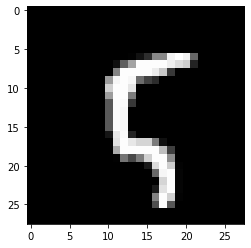

Gradient (784,)


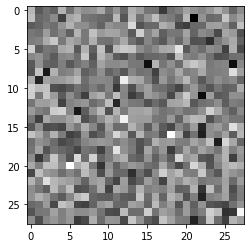

Hessian Diag matrix (28, 28)


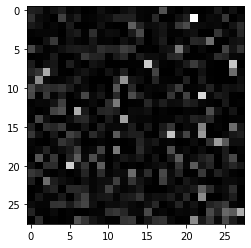

Hessian matrix (784, 784)


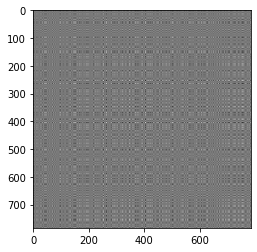

Input to maximize FI (28, 28)


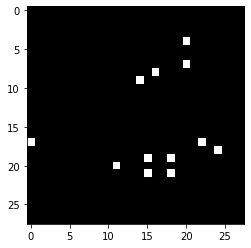

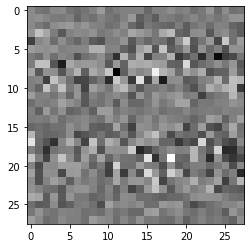

In [213]:
idx = 100

x_true = x_train[idx].reshape(1, 28, 28)
y_true = y_train[idx].reshape(1, -1)
y_pred = model.output

init = tf.global_variables_initializer()
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
get_grad = K.gradients(loss, model.input)

sess = K.get_session()
sess.run(init)
gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})

# gradient = gradient.flatten()
gradient = gradient.reshape(-1)
hessian_matrix = np.outer(gradient, gradient)


eig_values, eig_vectors = np.linalg.eigh(hessian_matrix)

eig_values = eig_values.astype(np.float32)
eig_vectors = eig_vectors.astype(np.float32)

for i in range(len(eig_vectors)):
    eig_vectors[i] = eig_vectors[i] / np.linalg.norm(eig_vectors[i], ord=2)
    
max_eig_vector = eig_vectors[np.argmax(eig_values)]


# Original

print("Original", x_true.shape)
plt.imshow(x_true.reshape(28,28), "gray")
plt.show()


# Gradient

print("Gradient", gradient.shape)
plt.imshow(gradient.reshape(28,28), "gray")
plt.show()


# Hessian (diag)

print("Hessian Diag matrix", np.diag(hessian_matrix).reshape(28,28).shape)
plt.imshow(np.diag(hessian_matrix).reshape(28,28), "gray")
plt.show()

# Hessian (diag)

print("Hessian matrix", hessian_matrix.shape)
plt.imshow(hessian_matrix, "gray")
plt.show()

# maximize FisherInformation

print("Input to maximize FI", max_eig_vector.reshape(28,28).shape)

max_fim = max_eig_vector.reshape(28,28)
max_fim = (max_fim - max_fim.min()) / (max_fim.max() - max_fim.min())
plt.imshow(np.where(max_fim < 0.8, 0, 1), "gray")
plt.show()

plt.imshow(max_eig_vector.reshape(28,28), "gray")
plt.show()

In [ ]:
fisher_info_matrix= np.zeros((784,784))
for idx in tqdm(range(len(hessian_matrix_list))):
    fisher_info_matrix = (idx / (idx + 1)) * hessian_matrix_list[idx] + (1 / (idx + 1)) * fisher_info_matrix